In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using matplotlib backend: MacOSX


逻辑回归(Logistic Regression), 是使用回归的实现的分类算法，只能解决二分类问题. 在Kaggle竞赛中，LR算法以63.5，荣获"出场率最高算法"

$$
\hat{p}=f(x) \quad \hat{y}=\left\{\begin{array}{ll}
1, & \hat{p} \geq 0.5 \\
0, & \hat{p} \leq 0.5
\end{array}\right.
$$

假定f(x)为一个线性回归问题，他的值域(-infinity,+infinity)

$$
f(x)=\theta^{T} \cdot x_{b}
$$

使用Sigmoid函数限定为概率的值域`[0,1]`

$$
\sigma(t)=\frac{1}{1+e^{-t}}
$$


## Sigmoid函数


$$
\sigma(t)=\frac{1}{1+e^{-t}}
$$

值域(0,1)

- t0时候, p=0.5
- t>0时候, p>0.5
- t<0时候, p<0.5

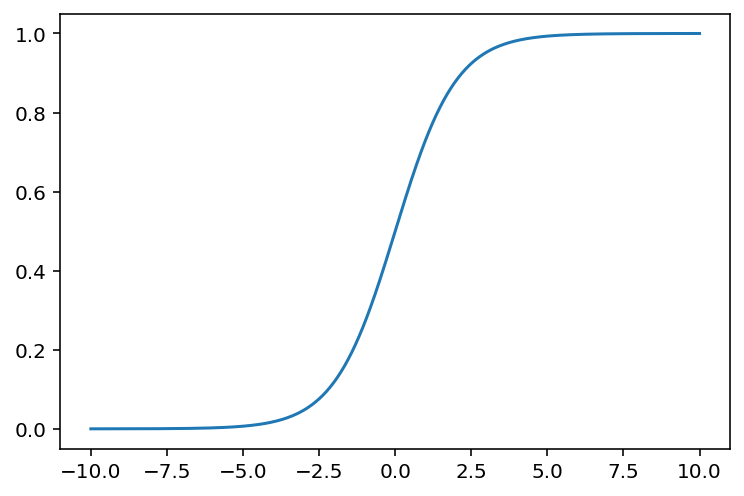

In [4]:
# 返回e的幂次方，e是一个常数为2.71828。将线性方程转化为0-1之间的概率。
def sigmoid(t):
    return 1.0 / (1+np.exp(-t))

x = np.linspace(-10, 10, 500)
plt.plot(x, sigmoid(x))
plt.show()

## 实现逻辑回归

**逻辑回归的模型**

$$
\hat{p}=\sigma\left(f(x)\right)=\sigma\left(\boldsymbol{\theta}^{T} \cdot x_{b}\right)=\frac{1}{1+e^{-\theta^{T} \cdot x_{b}}}
$$


$$
\hat{y}=\left\{\begin{array}{ll}
1, & \hat{p} \geq 0.5 \\
0, & \hat{p} \leq 0.5
\end{array}\right.
$$

问题: 给定的样本集X,y, 如何找到对应的参数Theta(使用梯度下降搜索),是的最大程度获得样本数据集X对应的分类输出y? 

解决方法: 最小话损失函数，使用梯度下降找到对应的Theta

**假设损失函数**
从逻辑回归的模型可看出

- 当y=1时, p值越小，损失越大；p值越大，损失越小。
- 当y=0时, p值越小，损失越小；p值越大，损失越大。

用一下函数来模拟这个现象:

![](https://cdn.mathpix.com/snip/images/qTmDAcJcnync8BvCYSpr77Bq8IjGYhJfiRkQprQQ9oA.original.fullsize.png)

进一步推导:

$$
\operatorname{cost}=-y \log (\hat{p})-(1-y) \log (1-\hat{p})
$$

=>

$$
J(\theta)=-\frac{1}{m} \sum_{i=1}^{m} y^{(i)} \log \left(\hat{p}^{(i)}\right)+\left(1-y^{(i)}\right) \log \left(1-\hat{p}^{(i)}\right)
$$

=>

$$
J(\theta)=-\frac{1}{m} \sum_{i=1}^{m} y^{i n} \log \left(\sigma\left(X_{b}^{(i)} \theta\right)\right)+\left(1-y^{(i)}\right) \log \left(1-\sigma\left(X_{b}^{(i)} \theta\right)\right)
$$

$$
\nabla J(\theta)=\frac{1}{m} \cdot\left(\begin{array}{c}
\sum_{i=1}^{m}\left(\hat{y}^{(i)}-y^{(i)}\right) \\
\sum_{i=1}^{m}\left(\hat{y}^{(i)}-y^{(i)}\right) \cdot X_{1}^{(i)} \\
\sum_{i=1}^{m}\left(\hat{y}^{(i)}-y^{(i)}\right) \cdot X_{2}^{(i)} \\
\cdots \\
\sum_{i=1}^{m}\left(\hat{y}^{(i)}-y^{(i)}\right) \cdot X_{n}^{(i)} \\
\end{array}\right)
=\frac{1}{m} \cdot X_{b}^{T} \cdot\left(\sigma\left(X_{b} \theta\right)-y\right)
$$

以上方程无公式解, 只能使用梯度下降法求解

In [7]:
class LogisticRegression:
    def __init__(self):
        pass
    
    def _sigmoid(self, t):
        return 1.0 / (1+np.exp(-t))
    
    def fit():
        pass
    
    def predit():
        pass
    
    def sore():
        pass

In [2]:
from sklearn import datasets

In [3]:
iris = datasets.load_iris()

In [20]:
# 取前两列特征，target里花的种类也只取两种
x = iris.data[y<2, :2]
y = iris.target[y<2]

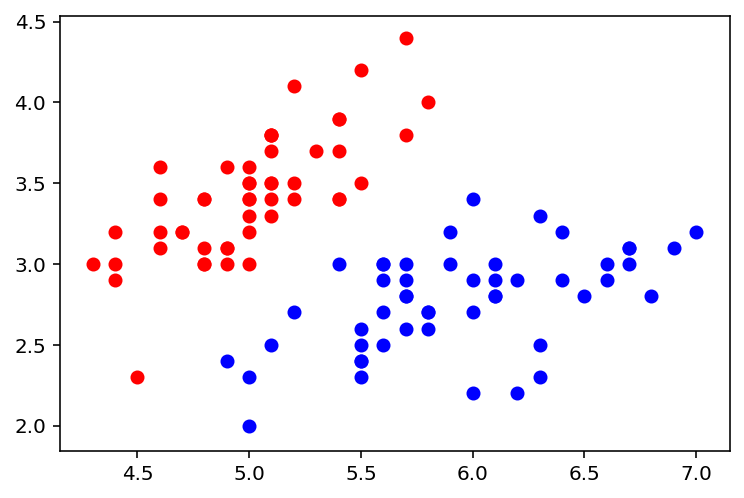

In [25]:
plt.scatter(x[y==0,0], x[y==0,1], color='red')
plt.scatter(x[y==1,0], x[y==1,1], color='blue')
plt.show()